In [95]:
import json
import pandas as pd
import requests
import datetime
from binance import Client
import matplotlib.pyplot as plt
import numpy as np
import os
from binance.client import Client
import datetime, time
from datetime import datetime
from numba import jit

# Бэктест_начало


In [96]:
# Требуется собрать данные в датафрейм df 
# Задаем даты начала и конца бектеста
start_date = '11/05/2022'
end_date = '11/08/2022'
# interval = '5 min' # '15 min', '30 min'

def GetHistoricalData(symbol, interval, fromDate, toDate):
    klines = client.get_historical_klines(symbol, interval, fromDate, toDate)
    df = pd.DataFrame(klines, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    df.dateTime = pd.to_datetime(df.dateTime, unit='ms')
    df['date'] = df.dateTime.dt.strftime("%d/%m/%Y")
    df['time'] = df.dateTime.dt.strftime("%H:%M:%S")
    df = df.drop(['dateTime', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)
    column_names = ["date", "time", "open", "high", "low", "volume"]
    df = df.reindex(columns=column_names)
    return df
    
api_key = ""
api_secret = ""
client = Client(api_key, api_secret)


fromDate = str(datetime.strptime(start_date, '%d/%m/%Y'))
toDate = str(datetime.strptime(end_date, '%d/%m/%Y'))
symbol = "ETHUSDT"
interval = Client.KLINE_INTERVAL_5MINUTE
df = GetHistoricalData(symbol, interval, fromDate, toDate)

## Определим 3 функции прибыли:  
Пока они вне класса, нужно внести их. 


In [209]:
# def unforward_earnings(start_price, end_price, high_board, low_board):
#     """Функция должна получить всю необходимую информацию и возвратить итоговую прибыль-убыток в пуле.
#     Тут не учитываются заработанные комиссии. Только изменение стоимости токенов и их соотношение.
#     Внимание!!!! Тут есть допущения - вкладываются равные части вверх и вниз"""
#     # Если после 24(или другого) периода цена оказалась выше изначальной
#     if end_price >= start_price:
#         res =  ((min(end_price, high_board)-start_price)/2+start_price)/start_price*0.5+0.5
#     elif end_price < start_price:
#         res =  (0.5/((start_price - max(end_price, low_board))/2 + max(end_price, low_board)) + 0.5/start_price)*end_price
#     return (res-1)*100 # возвращаем результат в процентах!
def unforward_earnings(start_price, end_price, high_board, low_board):
    """Функция должна получить всю необходимую информацию и возвратить итоговую прибыль-убыток в пуле.
    Тут не учитываются заработанные комиссии. Только изменение стоимости токенов и их соотношение"""
    # Если после 24(или другого) периода цена оказалась выше изначальной
    p_ETH = (high_board-start_price)/(high_board-low_board)# доля ETH
    p_USDT = (1-p_ETH)# доля USDT
    if end_price >= start_price:
        if end_price >= high_board:
            res = ((high_board-start_price)/2+start_price)/start_price*p_ETH+p_USDT
        else:
            p = (end_price-start_price)/(high_board-start_price) # доля проданного ETH
            a1 = ((end_price-start_price)/2+start_price)/start_price*p*p_ETH
            a2 = p_USDT
            a3 = p_ETH*(1-p)*(end_price)/start_price #непроданный ETH
            res =  a1+a2+a3
    elif end_price < start_price:
        if end_price <= low_board:
            res = (p_USDT/(low_board+(start_price - low_board)/2)+p_ETH/start_price)*end_price
        else:
            p = (start_price-end_price)/(start_price-low_board) # доля обменянных долларов
            a1 = p_USDT*p/(end_price+(start_price - end_price)/2)*end_price# сумма от обменянных долларов
            a2 = p_USDT*(1-p) # остатки долларов
            a3 = p_ETH*end_price/start_price# изначальный подешевевший эфир
            res =  a1+a2+a3
    return (res-1)*100 # возвращаем результат в процентах!

def simple_hedge(start_price, end_price, ratio):
    '''Данная функция принимает начальную и конечную стоимость. А так же параметры хеджирования - долю хеджа
    Возвращает процентный заработок/убыток из за хеджа в % '''
    res = -(end_price-start_price)/start_price
    return res*100*ratio

def persentage_earnings(const=1):
    '''Функция принимает необходимые параметры и рассчитывает доходность в % от всех изначальных инвестиций
    Для начала используем константу - 1%'''
#     res = const
    res = 1 # тут ручками задать 
    return res

def calc_ratio(start_price, high_board, low_board):
    return (high_board-start_price)/(high_board-low_board)
    


In [203]:
################### Инициализация параметров обучения ######################
n_info = 24 # часов для обучения (не совсем обучение, скорее зависимая часть)
n_forcast = 24 # на какой период предсказываем
intervals_in_hour = 12 # какими интервалами оперируем здесь 12 - 5 минутки

### Далее класс, его просто инициализировать

In [204]:
# Класс который принимаем в себя всю необходимую информацию и подготавливает данные, рассчитывает интервалы и тп
class Interval_calculator:
    def __init__(self, df, n_info, n_forcast, intervals_in_hour):
        self.df = df
        self.n_info = n_info
        self.n_forcast = n_forcast
        self.intervals_in_hour = intervals_in_hour
        self.make_new_col()
        self.preob()
        self.calculate_intervals()
        self.make_data_for_back()
        self.get_periodic()
        
    def make_new_col(self):
        '''Потребуются относительные изменения'''
        print('Добавляю относительные изменения')
        df = self.df
        mass = np.zeros(len(df))
        mass[0] = 1 # первую точку доопределяем 1
        values = df['open'].values.astype(float)
        for i in range(1, len(df)):
            mass[i] = values[i]/values[i-1]
            df['change'] = mass
        self.df = df
        return    
        
        
    def preob(self):
        '''Функция просто создает кучу разбивок для бутстрэпа и предсказания
        df - датасет
        n_info - сколько часов брать для "обучения"
        n_forcast - на сколько часов давать прогноз
        intervals_in_hour - количество выбранных интерваллов в часе (если минутные данные то 60)
        '''
        print('Создаю разбивку - данные для рассчета интервала и теста')
        df, n_info, n_forcast, intervals_in_hour = self.df, self.n_info, self.n_forcast, self.intervals_in_hour
        self.dict_res = {}
        for i in range(n_info*intervals_in_hour, len(df)-n_forcast*intervals_in_hour):
            fold_info = df[i-n_info*intervals_in_hour : i] # Срез датасета
            fold_res = df[i : i+n_forcast*intervals_in_hour] # Срез датасета
            self.dict_res[i] = [fold_info, fold_res] # В словаре лежат два датасета под каждым ключом
        return 
    
    @jit
    def bootstrap(self, mass, n_forcast, intervals_in_hour):
        '''Функция бутстрэпит изменения за прошедшие часы (это длина массива) n_forcast*intervals_in_hour раз, 
        процедура повторяется 10000 раз, в резульатате мы перемножеаем значения и выдаем прогноз в каждой точке таким образом (10000 симуляций)'''
        mass_res = np.zeros((10000, 2)) # 2 - нижняя и верхняя границы для каждой симуляции
        mass = np.array(mass) # переводим в numpy
        n = len(mass) # длина выборки для обучения
        size_forecast = n_forcast*intervals_in_hour
        # случайно берем числа до n, размера n_forcast*intervals_in_hour
        indexes = np.random.randint(n, size=size_forecast*10000)
        change = mass[[indexes]]
        change = change.reshape((10000, size_forecast))
        # теперь рассомтрим куммулятивное перемножение- предсказанное поведение
        cum_change = np.cumprod(change, axis=1)
        # минимальное и максимальные значения внутри временного интервалла
        min_ = np.min(cum_change, axis=1)
        max_ = np.max(cum_change, axis=1)
        sorted_res_min = np.sort(min_)
        sorted_res_max = np.sort(max_)
        high, low = sorted_res_max[9500], sorted_res_min[500]
        return np.array([high, low])
    
    def get_real(self, df):
      '''Функция нужна для валидации - возвращает верхние и нижние границы'''
      high = (df['high'].values.astype(float))
      low = (df['low'].values.astype(float))
      return np.hstack([high, low])
    
    def calculate_intervals(self):
        print('Рассчитываю интерваллы')
        dict_res, n_forcast, intervals_in_hour = self.dict_res, self.n_forcast, self.intervals_in_hour
        calculated_intervals = np.zeros((len(dict_res), 2))
        real_intervals = np.zeros((len(dict_res), n_forcast*intervals_in_hour*2)) # запоминаем  всю динамику  умножение на 2 тк записываем для верха и для низа
        k = 0
        for key in dict_res:
            real_intervals[k, :] = self.get_real(dict_res[key][1])

            # требуется для абсолютных значений запомнить цену открытия
            last_value = dict_res[key][0]['open'].values.astype(float)[-1]

            calculated = self.bootstrap(dict_res[key][0]['change'].values, n_forcast, intervals_in_hour)

            calculated_intervals[k, 0:2] = calculated*last_value

            k += 1
            j = int(len(dict_res)/200)
            if k % j == 0:
                print('progress = {} %'.format(round(k/len(dict_res)*100, 3)))
        self.intervals = calculated_intervals, real_intervals
        return

    def make_data_for_back(self):
        print('Преобразую данные для бэктеста')
        intervals, n_forcast, intervals_in_hour = self.intervals, self.n_forcast, self.intervals_in_hour
        # mass high, low, start, end
        k_end = n_forcast*intervals_in_hour-1
        mass = np.zeros((len(intervals[0]), 4))
        for i in range(len(intervals[0])):
            mass[i, :] = *intervals[0][i] , intervals[1][i][0], intervals[1][i][k_end]
    #         intervals[0][i] - high, low
    #         intervals[1][i][0] - start
    #         intervals[1][i][k] - end
        self.data_for_back = mass
        return

    def make_data_for_back(self):
        intervals, n_forcast, intervals_in_hour = self.intervals, self.n_forcast, self.intervals_in_hour
        # mass high, low, start, end
        k_end = n_forcast*intervals_in_hour-1
        mass = np.zeros((len(intervals[0]), 4))
        for i in range(len(intervals[0])):
            mass[i, :] = *intervals[0][i] , intervals[1][i][0], intervals[1][i][k_end]
    #         intervals[0][i] - high, low
    #         intervals[1][i][0] - start
    #         intervals[1][i][k] - end
        self.data_for_back = mass
        return
    
    def dynamic_hedge(self, i, price_for_f=0.1, hedge_activation=0.01):
        all_sum = 0
        hedge_activated = 0
        intervals, n_forcast, intervals_in_hour = self.intervals, self.n_forcast, self.intervals_in_hour
        i = i*n_forcast*intervals_in_hour
        start_price = intervals[1][i][0]
        end_price = intervals[1][i][intervals_in_hour*n_forcast-1]
        highs = intervals[1][i][:intervals_in_hour*n_forcast]
        lows = intervals[1][i][intervals_in_hour*n_forcast:]
        for j in range(len(highs)):
            # Если нет хеджа и цена пошла вниз, открываем позицию, платим премию
            if hedge_activated == 0 and lows[j] < (1-hedge_activation)*start_price:
                hedge_activated = 1
                all_sum -= price_for_f
            # Если цена пошла вверх, нужно закрыть хедж если он существует, заплатив за это
            elif hedge_activated == 1 and highs[j] > (1+hedge_activation)*start_price:
                hedge_activated = 0
                all_sum += -(highs[j]-start_price*(1-hedge_activation))/start_price*100
        if hedge_activated == 1:
            all_sum += -(end_price-start_price*(1-hedge_activation))/start_price*100
        
        return all_sum
    
    def option_hedge(self, i, price_o = 0, strike=0.99):
        '''Данная функция принимает стоимость опциона, и выдает конечную прибыль или убыток
        , убыток не больше стоимости опциона. Стоимость опциона выражается в процентах'''
        start = self.periodic_data_for_back[i, :][2]
        end = self.periodic_data_for_back[i, :][3]
        # затраты на опцион
        res = -price_o
        # покупаем опицон со страйком strike = 0.99 от цены старта, если цена ушла ниже страйка то добавляем прибыль
        if start*strike > end:
            res += (start*strike-end)/start*100 # результат в процентах
        return res
        
    
    def get_periodic(self):
        data_for_back, n_forcast, intervals_in_hour = self.data_for_back, self.n_forcast, self.intervals_in_hour
        '''Просто обрезка, выбор каждого n часового результата'''
        self.periodic_data_for_back = data_for_back[::n_forcast*intervals_in_hour, :]
        return 
    
    def back_test(self, ratio_for_hedge, hadge_type='simple', dyn_price=0.1, hedge_activation=0.01,  const_earnings=1,
                 price_o=0, strike=0.99):
        '''Функция проводит анализ стратегии, возвращает список прибыли/убытков в каждый период'''
        mass_for_back, n_forcast = self.periodic_data_for_back, self.n_forcast
        earnings = np.zeros(len(mass_for_back))
#         print(ratio_for_hedge, hadge_type)
        for i in range(len(mass_for_back)):
            high_board, low_board, start_price, end_price = mass_for_back[i, :]

            e1 = unforward_earnings(start_price, end_price, high_board, low_board)
            # тут есть допущение - хедж для нас не требует блокировку активов - фьючерсы в общем ,причем бесплатные
            if hadge_type == 'simple':
                ratio_for_hedge = calc_ratio(start_price, high_board, low_board)
                e2 = simple_hedge(start_price, end_price, ratio_for_hedge)
            elif hadge_type == 'f':
                e2 = self.dynamic_hedge(i, price_for_f=dyn_price, hedge_activation=hedge_activation)
            elif hadge_type == 'o':
                e2 = self.option_hedge(i, price_o=price_o, strike=strike)
            e3 = persentage_earnings(const_earnings)*n_forcast/24
            earnings[i] = e1+e2+e3
        return earnings
    
    
    def plot_results(self, hedges, add_dynamic=False, add_o=False, dyn_price=0.1, hedge_activation=0.01, const_earnings=1, price_o=0, strike=0.99):
        fig = plt.figure(figsize = (10, 10))
        mass_for_back = self.periodic_data_for_back
        x = range(0, len(mass_for_back)*8, 8)
    #     x = range(0, len(mass_for_back))
        for hedge in hedges:
            earnings = self.back_test(hedge, const_earnings=const_earnings)
            y = np.cumsum(earnings)
            plt.plot(x, y, label = 'hedge = {}'.format(hedge))
            plt.xlabel('Время в часах с начала стратегии', fontsize=15)
            plt.ylabel('Доходность в %', fontsize=15)
            plt.title('Анализ итоговой доходности при использовании стратегии', fontsize = 15)
        if add_dynamic:
            earnings = self.back_test(0, hadge_type='f', dyn_price=dyn_price, hedge_activation=hedge_activation, 
                                      const_earnings=const_earnings)
            y = np.cumsum(earnings)
            plt.plot(x, y, label = 'dynamic_hedge')
        if add_o:
            earnings = self.back_test(0, hadge_type='o', price_o=price_o, strike=strike)
            y = np.cumsum(earnings)
            plt.plot(x, y, label = 'option')
        plt.legend(prop={'size': 10})
        
    def plot_price(self):
        # Просто отрисовка того, как изменялся курс, чтобы интерпретировать прибыли и убытки в стратегии
        mass_for_back = self.periodic_data_for_back
        fig = plt.figure(figsize = (10, 10))
        plt.plot(mass_for_back[:, 3])
        plt.title('Курс ETH/USDT')
        
    def change_price_distr(self):
        mass_for_back = self.periodic_data_for_back
        change = np.zeros(len(mass_for_back))
        starts = mass_for_back[:, 2]
        ends = mass_for_back[:, 3]
        for i in range(len(change)):
            end = ends[i]
            start = starts[i]
            res = (end - start)/start*100 # итог в процентах +10% или -0.5%
            change[i] = res
        fig = plt.figure(figsize = (10, 10))
        plt.xlabel('Изменение стоимости в %', fontsize=15)
        plt.hist(change, bins=15)
        plt.show()

    


### Следующая строчка посчитает все интерваллы, минут 30 будет считать для 3х месяцев

In [205]:
back_test_obj = Interval_calculator(df, n_info, n_forcast, intervals_in_hour)

Добавляю относительные изменения
Создаю разбивку - данные для рассчета интервала и теста
Рассчитываю интерваллы


<ipython-input-204-6188eb93c25a>:44: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "bootstrap" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-204-6188eb93c25a> (48)

File "<ipython-input-204-6188eb93c25a>", line 48:
    def bootstrap(self, mass, n_forcast, intervals_in_hour):
        <source elided>
        процедура повторяется 10000 раз, в резульатате мы перемножеаем значения и выдаем прогноз в каждой точке таким образом (10000 симуляций)'''
        mass_res = np.zeros((10000, 2)) # 2 - нижняя и верхняя границы для каждой симуляции
        ^

  @jit
/Users/vladislav705/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "bootstrap" was compiled in object mode without forceobj=True.

File "<ipython-input-204-6188eb93c25a>", line 45:
    @jit
    def bootstrap(self, mass, n_forcast, intervals_in_hour):
    ^

  warnings.warn(erro

KeyboardInterrupt: 

### Следующая строка считает доходность в данной стратегии (возможно часы внизу не корректно указаны, по идее тут все 3 месяца)

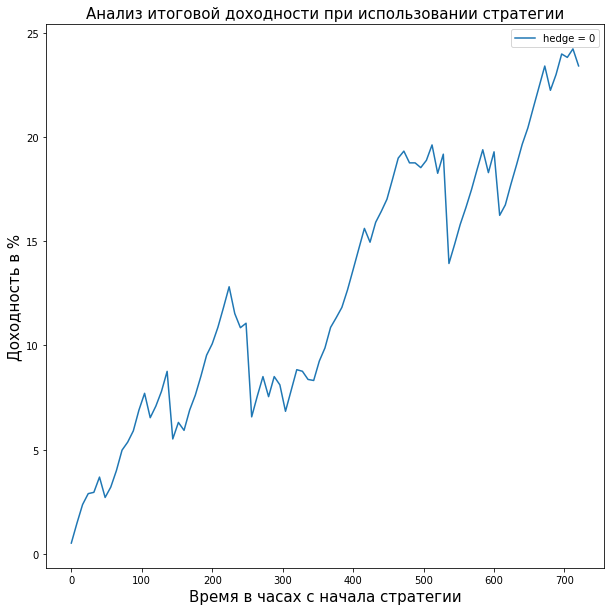

In [211]:
back_test_obj.plot_results(hedges)

### Рассмотрим как изменялся курс ETH/USDT

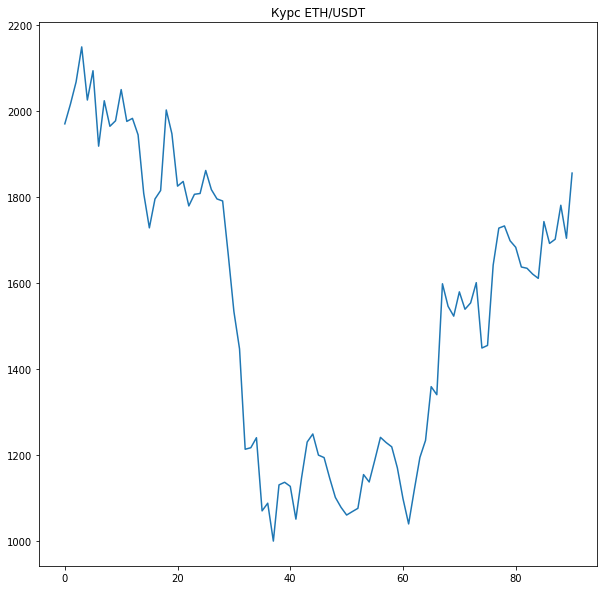

In [175]:
back_test_obj.plot_price()

### Дополнительно проверим как распределены изменения в стоимости (после 24 часов)¶


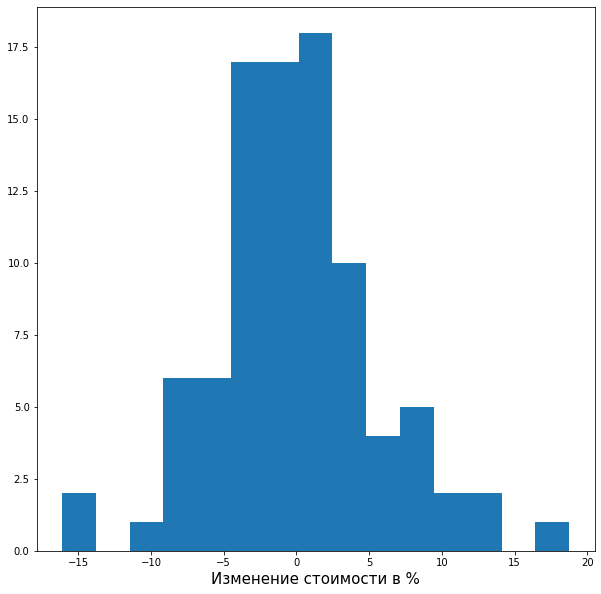

In [198]:
back_test_obj.change_price_distr()

# проверка логики работы

In [212]:
# Функция для построения кривой
def simulate(start_price, end, high_board, low_board, hedge, earnings):
    a1 = unforward_earnings(start_price, end, high_board, low_board)
    a2 = earnings
    a3 = -hedge*(end - start_price)/start_price*100
    return a1+a2+a3

In [194]:
start_price = 100
high_board = 110
low_board = 50
hedge = 0.1666666666
earnings = 0.5
end_prises = list(range(80,120))
list2 = list(map((lambda x: simulate(start_price, x, high_board, low_board, hedge, earnings)), end_prises))
list3 = list(map((lambda x: x-100), end_prises))


In [195]:
# Как рассчитать долю хеджа
(110-100)/(110-50)

0.16666666666666666

## Сама картинка (если что-то не видно, чтоит поменять ylim)

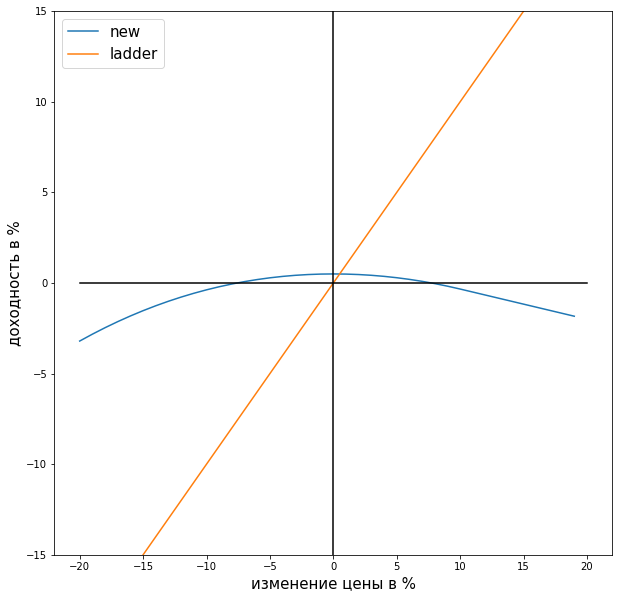

In [197]:
plt.figure(figsize=(10,10))
plt.plot(list3, list2, label='new')
plt.plot(list3, list3, label='ladder')
plt.plot([0, 0], [-20, 20], c='black')
plt.plot([-20, 20], [0, 0], c='black')
plt.xlabel('изменение цены в %', fontsize=15)
plt.ylabel('доходность в %', fontsize=15)
plt.ylim([-15, 15])
plt.legend(prop={'size':15})